In [2]:
from src.preprocessing import clean

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot')

## Data preprocessing

### Clean tweets

In [3]:
STOPWORDS = stopwords.words('english')

In [4]:
def get_vocabulary(iter_sents):
    vocab = set()
    max_length = 0
    for text in iter_sents:
        tokens = text.split(' ')
        if len(tokens) > max_length:
            max_length = len(tokens)
        vocab.update(tokens)
    return vocab, max_length

In [5]:
# Read & split train test
filename = './data/entire_corpus.csv'
df = pd.read_csv(filename)
df_train = df[df['source'] == 'train'].copy()
df_test = df[df['source'] == 'test'].copy()

# Clean
df_train['text'] = df_train['text'].apply(clean)
df_test['text'] = df_test['text'].apply(clean)

# Remove digits
df_train['text'] = df_train['text'].apply(lambda x: re.sub(r'\w*\d\w*', '', x).strip())
df_test['text'] = df_test['text'].apply(lambda x: re.sub(r'\w*\d\w*', '', x).strip())

# Remove stop words
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([w for w in x.split(' ') if w not in STOPWORDS]))
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([w for w in x.split(' ') if w not in STOPWORDS]))

In [7]:
# Lemmatizing
lemm = WordNetLemmatizer()

def lemmatize(text):
    words = text.split(' ')
    words = [lemm.lemmatize(w) for w in words]
    words = [lemm.lemmatize(w, pos='a') for w in words]
    words = [lemm.lemmatize(w, pos='v') for w in words]
    return ' '.join(words)

df_train['text'] = df_train['text'].apply(lemmatize)
df_test['text'] = df_test['text'].apply(lemmatize)

### Vectorize tweets using TF-IDF

In [8]:
# Vectorize
tfidf = TfidfVectorizer()
data_matrix = tfidf.fit_transform(df_train.text)

X_train = data_matrix.toarray()
X_test = tfidf.transform(df_test.text).toarray()
y_train = df_train['target'].values
y_test = df_test['target'].values

## Training & Evaluating models

### Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression

parameters = {'C': [10, 1, 0.1, 0.01, 0.001]}
logreg = LogisticRegression()
model = GridSearchCV(logreg, parameters, verbose=1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Light\.virtualenvs\disaster-EXdKZbpW\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  2.8min finished


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001]}, verbose=1)

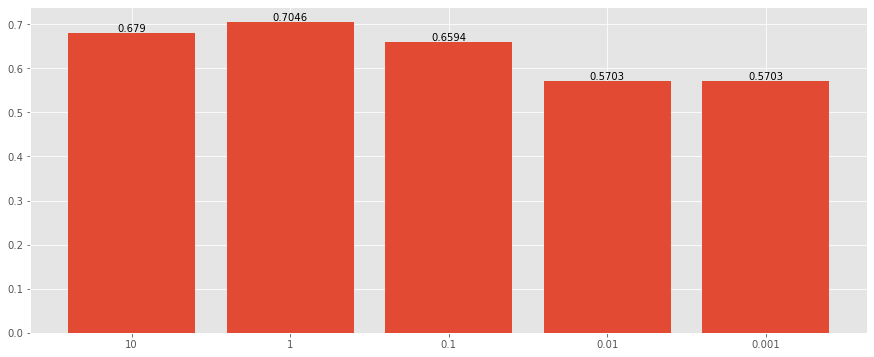

In [48]:
stats = pd.DataFrame(model.cv_results_)

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(stats['param_C'].astype(str), stats['mean_test_score'])
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height, 4), ha='center', va='bottom')

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix

model = LigosticRegression(C=1.0)

def show_performance(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print(f"Accuracy : {accuracy_score(y_test, pred)}")
    print(f"F1-score : {f1_score(y_test, pred)}")

    plot_confusion_matrix(model, X_test, y_test,
                        display_labels=['0', '1'],
                        cmap=plt.cm.Blues,
                        normalize=True)
    
show_performance(model)

#### SVM

In [ ]:
from sklearn.svm import SVC

parameters = {'C': [1.5, 1.0, 0.5],
             'kernel': ['poly'],
             'degree': [2, 3, 4]}
model = SVC()
grid = GridSearchCV(model, parameters, verbose=1)
grid.fit(X_train, y_train)

In [ ]:
stats = pd.DataFrame(grid.cv_results_)
stats



In [ ]:
model = SVC(grid.best_params_)
show_performance(model)

### Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

parameters = {'alpha': [2.0, 1.5, 1.0, 0.5, 0.01],}
model = MultinomialNB()
grid = GridSearchCV(model, parameters, verbose=1)
grid.fit(X_train, y_train)

In [ ]:
stats = pd.DataFrame(grid.cv_results_)

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(stats['param_C'].astype(str), stats['mean_test_score'])
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height, 4), ha='center', va='bottom')

In [ ]:
model = MultinomialNB(grid.best_params_)
show_performance(model)